In [ ]:
import numpy as np
import pathlib
import glob
import cv2
import os
import gc # garbage collection to save memory

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from google.colab.patches import cv2_imshow
from typing import List, Tuple

try:
    from tensorflow import keras
except ModuleNotFoundError:
    print("installing tensorflow")
    !pip install --quiet -q tensorflow
    from tensorflow import keras

try:
    import tensorflow_addons as tfa
except ModuleNotFoundError:
    print("installing tensorflow addons for cyclical learning rate")
    !pip install -q --quiet -U tensorflow_addons
    import tensorflow_addons as tfa

import tensorflow
from keras import layers, Sequential
from keras.engine.keras_tensor import KerasTensor
from keras.engine.functional import Functional
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.initializers import glorot_uniform
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, Add, \
                         Input, MaxPooling2D, AveragePooling2D, Maximum, \
                         Minimum, Average, Concatenate

In [2]:
# connect to google drive
from google.colab import drive
drive.mount("/content/gdrive")

MODELS_PATH = "gdrive/MyDrive/Colab_Notebooks/ComputerVision/assignment5/trained_models"
HISTORIES_PATH = "gdrive/MyDrive/Colab_Notebooks/ComputerVision/assignment5/model_histories"
MODEL_ARCHITECTURES_PATH = "gdrive/MyDrive/Colab_Notebooks/ComputerVision/assignment5/model_architectures"

if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)

if not os.path.exists(HISTORIES_PATH):
    os.makedirs(HISTORIES_PATH)

if not os.path.exists(MODEL_ARCHITECTURES_PATH):
    os.makedirs(MODEL_ARCHITECTURES_PATH)

Mounted at /content/gdrive


# Helper functions and global constants used throughout

In [3]:
def plotHistory(history, model_name):
    """Plots train and validation loss and accuracy"""
    fig = figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fig.suptitle(model_name + " history", fontsize=18)
    n_epochs = [i+1 for i in range(len(history.history["accuracy"]))]

    loss = history.history["loss"]
    validation_loss = history.history["val_loss"]
    ax1.plot(n_epochs, loss)
    ax1.plot(n_epochs, validation_loss)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylabel("loss")
    ax1.legend(["train loss", "validation loss"], loc="upper right")
    
    accuracy = history.history["accuracy"]
    validation_accuracy = history.history["val_accuracy"]
    ax2.plot(n_epochs, accuracy)
    ax2.plot(n_epochs, validation_accuracy)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylabel("accuracy")
    ax2.legend(["train accuracy", "validation accuracy"], loc="lower right")

    fig.text(0.5, 0.04, "Epoch", ha="center")

    plt.savefig(HISTORIES_PATH + "/" + model_name + "_history.png")
    plt.show()
    plt.clf()

def unfreeze(model, amt_unfreeze=0):
    """Unfreezes the last 'amt_unfreeze' layers from the given 'model',
    which means these layers are now trainable"""
    for idx, layer in enumerate(model.layers):
        layer.trainable = idx >= len(model.layers) - amt_unfreeze

def reset_model(model):
    """Makes all layers of the given 'model' trainable"""
    for layer in model.layers:
        layer.trainable = True

In [4]:
# paths to save the models
CKPT_PATH_STAN = MODELS_PATH + "/stan_model.ckpt"
CKPT_PATH_STAN_CLR = MODELS_PATH + "/stan_model_CLR.ckpt"
CKPT_PATH_HMDB_PRETRAINED = MODELS_PATH + "/hmdb_model.ckpt"
CKPT_PATH_FLOW = MODELS_PATH + "/flow_model.ckpt"
CKPT_PATH_FLOW_3D = MODELS_PATH + "/flow_model_3d.ckpt"

CKPT_PATH_TWO_STREAM_AVG = MODELS_PATH + "/two_stream_model_avg.ckpt"
CKPT_PATH_TWO_STREAM_CONC = MODELS_PATH + "/two_stream_model_conc.ckpt"
CKPT_PATH_TWO_STREAM_MAX = MODELS_PATH + "/two_stream_model_max.ckpt"
CKPT_PATH_TWO_STREAM_MIN = MODELS_PATH + "/two_stream_model_min.ckpt"

In [5]:
HEIGHT, WIDTH = 72, 72

# Stanford 40 dataset
### Functions to download and preprocess the data


In [6]:
!wget -qq http://vision.stanford.edu/Datasets/Stanford40_JPEGImages.zip
!wget -qq http://vision.stanford.edu/Datasets/Stanford40_ImageSplits.zip

### Unzip it

In [7]:
!unzip -qq Stanford40_JPEGImages.zip -d Stanford40/
!unzip -qq Stanford40_ImageSplits.zip -d Stanford40/

## Read the train and test splits, combine them and make better splits to help training networks easier.

In [8]:
def createTrainTest():
    """Only keeps 12 of the 40 action classes and splits the train and test files differently"""
    
    keep_stanford40 = [
        "applauding", 
        "climbing", 
        "drinking", 
        "jumping", 
        "pouring_liquid", 
        "riding_a_bike", 
        "riding_a_horse", 
        "running", 
        "shooting_an_arrow", 
        "smoking", 
        "throwing_frisby", 
        "waving_hands"
        ]
    
    with open("Stanford40/ImageSplits/train.txt", "r") as f:
        train_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
        train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
    
    with open("Stanford40/ImageSplits/test.txt", "r") as f:
        test_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
        test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]
    
    # Combine the splits and split for keeping more images in the training set than the test set.
    all_files = train_files + test_files
    all_labels = train_labels + test_labels
    train_files, test_files = train_test_split(all_files, test_size=0.1,random_state=0, stratify=all_labels)
    train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
    test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]

    # action_categories = sorted(list(set(train_labels)))
    
    return train_files, test_files, train_labels, test_labels

### Visualize a photo from the training files and also print its label

In [9]:
def visualizePhotoLabel(image_n: int, train_files: list, train_labels: list):
    """Visualizes a training image and its label
    - image_n: an integer in [0, 1200]
    - train_files: a list with all training images"""
    img = cv2.imread(f"Stanford40/JPEGImages/{train_files[image_n]}")
    print(img.shape)
    print(f"An image with the label - {train_labels[image_n]}")
    cv2_imshow(img)

# train_files, test_files, train_labels, test_labels = createTrainTest()
# visualizePhotoLabel(234)

###  Preprocess the images 
* shape
* scale in [0, 1]
* one-hot labels

In [10]:
def preprocessStanford(train_files: list, test_files: list, train_labels: list, test_labels: list):
    """Transforms the images to 72x72x3 and scales them in [0, 1].
    It also transforms the labels to one-hot vectors"""
    
    IMAGE_PATH = "Stanford40/JPEGImages/"

    all_x_train = [cv2.imread(IMAGE_PATH + img) for img in train_files]
    all_x_train = np.array([cv2.resize(img, (HEIGHT, WIDTH), interpolation=cv2.INTER_AREA) for img in all_x_train])
    all_x_train = all_x_train/255

    encoder = LabelBinarizer()
    all_y_train_cat = encoder.fit_transform(train_labels)

    x_test = [cv2.imread(IMAGE_PATH + img) for img in test_files]
    x_test = np.array([cv2.resize(img, (HEIGHT, WIDTH), interpolation=cv2.INTER_AREA) for img in x_test])
    x_test = x_test/255

    encoder = LabelBinarizer()
    y_test_cat = encoder.fit_transform(test_labels)

    return all_x_train, all_y_train_cat, x_test, y_test_cat

# ResNet
### Define the ResNet model

In [11]:
def identity_block(X: tensorflow.Tensor, level: int, block: int, filters: List[int]) -> tensorflow.Tensor:
    """
    Creates an identity block

    Input:
        X - input tensor of shape (m, height_prev, width_prev, chan_prev)
        level - integer, one of the 5 levels that our networks is conceptually divided into
              - level names have the form: conv2_x, conv3_x ... conv5_x
        block - each conceptual level has multiple blocks (1 identity and several convolutional blocks)
                block is the number of this block within its conceptual layer
                i.e. first block from level 2 will be named conv2_1
        filters - a list on integers, each of them defining the number of filters in each convolutional layer

    Output:
        X - tensor (m, height, width, chan)
    """

    # layers will be called conv{level}_iden{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the identity block
    # takes the value of the block input
    X_shortcut = X

    # first convolutional layer (plus batch norm & relu activation)
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    # X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1),
               padding='same', name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    # X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu')(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    # X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # relu activation at the end of the block
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

In [12]:
def convolutional_block(X: tensorflow.Tensor, level: int, block: int, filters: List[int], s: Tuple[int,int,int]=(2, 2)) -> tensorflow.Tensor:
    """
    Creates a convolutional block

    Input:
        X - input tensor of shape (m, height_prev, width_prev, chan_prev)
        level - integer, one of the 5 levels that our networks is conceptually divided into (see figure 3.1 in the readme file)
              - level names have the form: conv2_x, conv3_x ... conv5_x
        block - each conceptual level has multiple blocks (1 identity and several convolutional blocks)
                block is the number of this block within its conceptual layer
                i.e. first block from level 2 will be named conv2_1
        filters - a list on integers, each of them defining the number of filters in each convolutional layer
        s   - stride of the first layer;
            - a conv layer with a filter that has a stride of 2 will reduce the width and height of its input by half

    Output:
        X - tensor (m, height, width, chan)
    """

    # layers will be called conv{level}_{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the convolutional block
    X_shortcut = X

    # first convolutional layer
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=s, padding='valid',
               name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    # X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    # X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=2, type='relu'))(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    # X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # shortcut path
    X_shortcut = Conv2D(filters=f3, kernel_size=(1, 1), strides=s, padding='valid',
                        name=conv_name.format(layer='short', type='conv'),
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    # X_shortcut = BatchNormalization(axis=3, name=conv_name.format(layer='short', type='bn'))(X_shortcut)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # nonlinearity
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

In [13]:
def MyResNet(input_size: Tuple[int,int,int], classes: int) -> Model:
    """
        Builds the a modified version of the ResNet18 model

        Input:
            - input_size - a (height, width, chan) tuple, the shape of the input images
            - classes - number of classes the model must learn

        Output:
            model - a Keras Model() instance
    """

     # tensor placeholder for the model's input
    X_input = Input(input_size)

    ### Level 1 ###

    # convolutional layer, followed by batch normalization and relu activation
    X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),
               name='conv1_1_1_conv',
               kernel_initializer=glorot_uniform(seed=0))(X_input)
    # X = BatchNormalization(axis=3, name='conv1_1_1_nb')(X)
    X = Activation('relu')(X)

    ### Level 2 ###

    # max pooling layer to halve the size coming from the previous layer
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 1x convolutional block
    X = convolutional_block(X, level=2, block=1, filters=[64, 64, 256], s=(1, 1))
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)

    # 1x identity blocks
    X = identity_block(X, level=2, block=2, filters=[64, 64, 256])
    # X = identity_block(X, level=2, block=3, filters=[64, 64, 256])

    ### Level 3 ###

    # 1x convolutional block
    X = convolutional_block(X, level=3, block=1, filters=[128, 128, 512], s=(2, 2))

    # # 1x identity blocks
    X = identity_block(X, level=3, block=2, filters=[128, 128, 512])

    # Pooling layers
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # Output layer
    X = Flatten()(X)
    X = Dropout(0.5)(X) # added dropout 
    X = Dense(classes, activation='softmax', name='fc_' + str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='MyResNet')

    return model

# Run ResNet on Stanford data

In [14]:
train_files_stan, test_files_stan, train_labels_stan, test_labels_stan = createTrainTest()
all_x_train_stan, all_y_train_stan, x_test_stan, y_test_stan = preprocessStanford(train_files_stan, test_files_stan, train_labels_stan, test_labels_stan)
x_train_stan, x_val_stan, y_train_stan, y_val_stan = train_test_split(all_x_train_stan, all_y_train_stan, test_size=0.1,random_state=0, stratify=all_y_train_stan)

### Cyclical Learning Rate

In [15]:
BATCH_SIZE = 64
INIT_LR = 1e-5
MAX_LR = 1e-2

steps_per_epoch = len(x_train_stan) // BATCH_SIZE
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

callback_ckpt = ModelCheckpoint(CKPT_PATH_STAN_CLR, 
                               save_best_only=True, 
                               save_weights_only=True, 
                               monitor="val_loss", 
                               mode="min")

callback_early_stop = EarlyStopping(monitor="val_loss", 
                                    patience=10, 
                                    verbose=1, 
                                    mode="min", restore_best_weights=True)

model_stan = MyResNet(input_size=(HEIGHT,WIDTH,3), classes=12)

model_stan.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(clr),
                metrics="accuracy")

history_stan_CLR = model_stan.fit(x_train_stan, y_train_stan, batch_size=BATCH_SIZE,
                              epochs=35, validation_data=(x_val_stan, y_val_stan), verbose=1, 
                              shuffle=True, callbacks=[callback_ckpt, callback_early_stop])

Epoch 1/35
39/39 [==============================] - 20s 85ms/step - loss: 2.4660 - accuracy: 0.1070 - val_loss: 2.4112 - val_accuracy: 0.1642
Epoch 2/35
39/39 [==============================] - 2s 44ms/step - loss: 2.4844 - accuracy: 0.1094 - val_loss: 2.4992 - val_accuracy: 0.1241
Epoch 3/35
39/39 [==============================] - 2s 44ms/step - loss: 2.4114 - accuracy: 0.1509 - val_loss: 2.4472 - val_accuracy: 0.1460
Epoch 4/35
39/39 [==============================] - 2s 53ms/step - loss: 2.3051 - accuracy: 0.2005 - val_loss: 2.2571 - val_accuracy: 0.2080
Epoch 5/35
39/39 [==============================] - 2s 47ms/step - loss: 2.2319 - accuracy: 0.2200 - val_loss: 2.2294 - val_accuracy: 0.2044
Epoch 6/35
39/39 [==============================] - 2s 47ms/step - loss: 2.2298 - accuracy: 0.2107 - val_loss: 2.2118 - val_accuracy: 0.2372
Epoch 7/35
39/39 [==============================] - 2s 45ms/step - loss: 2.1779 - accuracy: 0.2444 - val_loss: 2.1333 - val_accuracy: 0.2482
Epoch 8/35
3

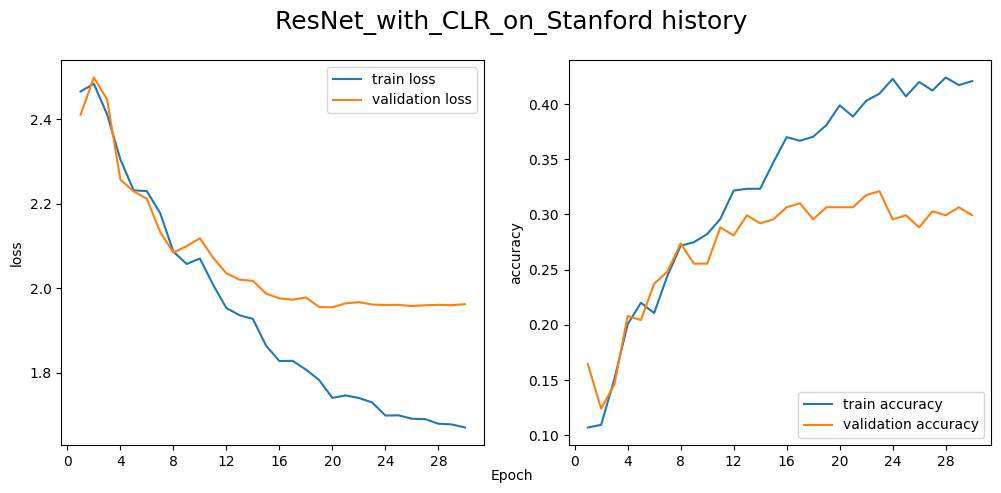

<Figure size 640x480 with 0 Axes>

In [16]:
plotHistory(history_stan_CLR, "ResNet_with_CLR_on_Stanford")

In [17]:
model_stan = MyResNet(input_size=(HEIGHT,WIDTH,3), classes=12)
model_stan.load_weights(CKPT_PATH_STAN_CLR).expect_partial()
model_stan.compile(loss="categorical_crossentropy",
                        optimizer=keras.optimizers.Adam(0.001),
                        metrics="accuracy")

model_stan.evaluate(x_test_stan, y_test_stan)

10/10 [==============================] - 1s 36ms/step - loss: 1.9503 - accuracy: 0.3355


[1.95026433467865, 0.33552631735801697]

### No Cyclical Learning Rate

In [85]:
model_stan = MyResNet(input_size=(HEIGHT,WIDTH,3), classes=12)

callback_ckpt = ModelCheckpoint(CKPT_PATH_STAN, 
                               save_best_only=True, 
                               save_weights_only=True, 
                               monitor="val_accuracy", 
                               mode="max")

callback_early_stop = EarlyStopping(monitor="val_accuracy", 
                                    patience=6, 
                                    verbose=1, 
                                    mode="max", restore_best_weights=True)

model_stan.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(0.001),
                metrics="accuracy")

history_stan = model_stan.fit(x_train_stan, y_train_stan, batch_size=64,
                              epochs=20, validation_data=(x_val_stan, y_val_stan), verbose=1, 
                              shuffle=True, callbacks=[callback_ckpt, callback_early_stop])

39/39 [==============================] - 2s 49ms/step - loss: 2.1583 - accuracy: 0.2672 - val_loss: 2.1016 - val_accuracy: 0.3212
Epoch 4/20
39/39 [==============================] - 2s 41ms/step - loss: 2.0191 - accuracy: 0.3030 - val_loss: 2.0920 - val_accuracy: 0.2591
Epoch 5/20
39/39 [==============================] - 2s 48ms/step - loss: 1.9268 - accuracy: 0.3449 - val_loss: 1.9746 - val_accuracy: 0.3467
Epoch 6/20
39/39 [==============================] - 2s 45ms/step - loss: 1.8412 - accuracy: 0.3798 - val_loss: 1.8896 - val_accuracy: 0.3358
Epoch 7/20
39/39 [==============================] - 2s 47ms/step - loss: 1.7293 - accuracy: 0.4095 - val_loss: 1.8335 - val_accuracy: 0.3613
Epoch 8/20
39/39 [==============================] - 2s 48ms/step - loss: 1.6663 - accuracy: 0.4274 - val_loss: 1.8017 - val_accuracy: 0.3796
Epoch 9/20
39/39 [==============================] - 2s 46ms/step - loss: 1.5672 - accuracy: 0.4591 - val_loss: 1.8001 - val_accuracy: 0.3869
Epoch 10/20
39/39 [=====

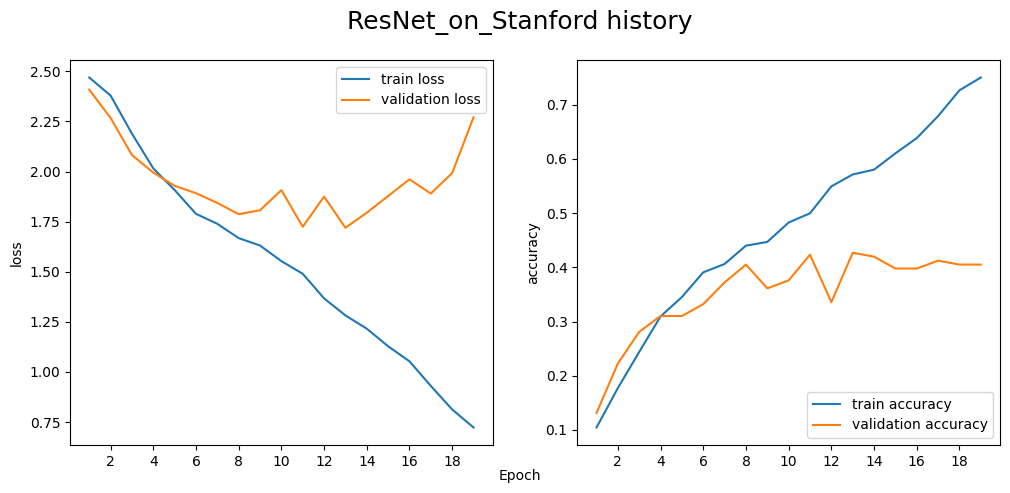

<Figure size 640x480 with 0 Axes>

In [19]:
plotHistory(history_stan, "ResNet_on_Stanford")

In [86]:
model_stan = MyResNet(input_size=(HEIGHT,WIDTH,3), classes=12)
model_stan.load_weights(CKPT_PATH_STAN).expect_partial()
model_stan.compile(loss="categorical_crossentropy",
                        optimizer=keras.optimizers.Adam(0.001),
                        metrics="accuracy")

model_stan.evaluate(x_test_stan, y_test_stan)

10/10 [==============================] - 1s 12ms/step - loss: 1.7131 - accuracy: 0.4178


[1.7131403684616089, 0.4177631437778473]

In [ ]:
plot_model(model_stan, to_file=MODEL_ARCHITECTURES_PATH + "/MyResNetModel.jpg", expand_nested=True, dpi=60, show_shapes=True)

In [24]:
gc.collect()
del model_stan, x_train_stan, x_val_stan, x_test_stan, y_train_stan, y_val_stan, y_test_stan
del all_x_train_stan, all_y_train_stan
!rm -r Stanford40

# Human Motion Database 51 (HMDB51)
### Functions to download and preprocess the data

In [21]:
try:
    import av
except ModuleNotFoundError:
    print("installing av")
    !pip install --quiet av
    import av

installing av
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 22.6 MB/s eta 0:00:00


In [22]:
# Download HMDB51 data and splits from serre lab website
! wget -qq http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
! wget -qq http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar

In [ ]:
! mkdir -p video_data test_train_splits
! unrar e test_train_splits.rar test_train_splits
! rm test_train_splits.rar
! unrar e hmdb51_org.rar 
! rm hmdb51_org.rar
! mv *.rar video_data

keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", 
        "run", "shoot_bow", "smoke", "throw", "wave"]
for files in os.listdir('video_data'):
    foldername = files.split('.')[0]
    if foldername in keep_hmdb51:
      # extract only the relevant classes for the assignment.
      os.system("mkdir -p video_data/" + foldername)
      os.system("unrar e video_data/" + files + " video_data/" + foldername)

! rm video_data/*.rar

In [24]:
def getTrainTestFiles():
    """Returns lists with the train and test files directorys and their labels"""
    keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", 
        "run", "shoot_bow", "smoke", "throw", "wave"]
    
    TRAIN_TAG, TEST_TAG = 1, 2
    train_files, test_files = [], []
    train_labels, test_labels = [], []
    split_pattern_name = f"*test_split1.txt"
    split_pattern_path = os.path.join('test_train_splits', split_pattern_name)
    annotation_paths = glob.glob(split_pattern_path)
    for filepath in annotation_paths:
        class_name = '_'.join(filepath.split('/')[-1].split('_')[:-2])
        if class_name not in keep_hmdb51:
            continue  # skipping the classes that we won't use.
        with open(filepath) as fid:
            lines = fid.readlines()
        for line in lines:
            video_filename, tag_string = line.split()
            tag = int(tag_string)
            if tag == TRAIN_TAG:
                train_files.append(video_filename)
                train_labels.append(class_name)
            elif tag == TEST_TAG:
                test_files.append(video_filename)
                test_labels.append(class_name)
    
    return train_files, test_files, train_labels, test_labels

In [25]:
def captureMiddle(vid_path: pathlib.PosixPath):
    """Returns the middle frame of the video file provided in vid_path"""
    cap = cv2.VideoCapture(str(vid_path))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Set the reader to the middle frame number
    cap.set(cv2.CAP_PROP_POS_FRAMES, length//2)

    ret, frame = cap.read()
    frame = cv2.resize(frame, (HEIGHT, WIDTH), interpolation=cv2.INTER_AREA)
    cap.release()
    
    return frame

In [26]:
def writeMiddleFrames(files: list, labels: list):
    """Saves the middle frame from each video
    - files: a list with the train/val/test filenames
    - labels: a list with the corresponding labels"""
    path = pathlib.Path.cwd() / "video_data"
    frame_path = pathlib.Path.cwd() / "frame_data"

    [(frame_path / label).mkdir(parents=True, exist_ok=True) for label in labels]    
    for idx, (file, label) in enumerate(zip(files, labels)):
        video_path = path / label / file
        img_path = frame_path / label / file.split(".")[0]

        frame = captureMiddle(video_path)
        cv2.imwrite(str(img_path) + ".jpg", frame)

### Custom data generator

In [27]:
class HMDBDataGenerator(keras.utils.Sequence):
    action_categories_hmdb = ["clap", "climb", "drink", "jump", "pour", "ride_bike", 
                              "ride_horse", "run", "shoot_bow", "smoke", "throw", "wave"]

    def __init__(self, data_dir, batch_size, files, labels):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.files = [data_dir / label / (str(file).split(".")[0] + ".jpg") for file, label in zip(files, labels)]
        self.labels = labels

    def __len__(self):
        return int(np.ceil(len(self.files) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_files = self.files[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Normalize images
        data = np.array([cv2.imread(str(file)) / 255 for file in batch_files])
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        """instead of using LabelBinarizer to one-hot encode the labels, 
        manually create one-hot encoded label vectors for each batch sample.
         This ensures that all labels are present in the output array, 
         even if they are not present in the current batch."""
        labels = []
        for label in batch_labels: 
            label_index = self.action_categories_hmdb.index(label)
            label_vector = np.zeros(len(self.action_categories_hmdb))
            label_vector[label_index] = 1
            labels.append(label_vector)
        labels = np.array(labels)

        return data, labels

# Run to save the middle frame and to define the data generators

In [28]:
all_train_files_hmdb, test_files_hmdb, all_train_labels_hmdb, test_labels_hmdb = getTrainTestFiles()
train_files_hmdb, val_files_hmdb, train_labels_hmdb, val_labels_hmdb = train_test_split(all_train_files_hmdb, all_train_labels_hmdb, test_size=0.1, random_state=0, stratify=all_train_labels_hmdb)

writeMiddleFrames(train_files_hmdb, train_labels_hmdb)
writeMiddleFrames(val_files_hmdb, val_labels_hmdb)
writeMiddleFrames(test_files_hmdb, test_labels_hmdb)

In [29]:
# Create generators for HMDB images
frame_path = pathlib.Path.cwd() / "frame_data"
train_gen_frame = HMDBDataGenerator(frame_path, 64, train_files_hmdb, train_labels_hmdb)
val_gen_frame = HMDBDataGenerator(frame_path, 64, val_files_hmdb, val_labels_hmdb)
test_gen_frame = HMDBDataGenerator(frame_path, 64, test_files_hmdb, test_labels_hmdb)

# Finetune the pre-trained ResNet on HMDB
### the last two layers (fully-connected and output) are trained anew on the hmdb dataset

In [94]:
model_hmdb_pretrained = MyResNet(input_size=(HEIGHT,WIDTH,3), classes=12)

model_hmdb_pretrained.compile(loss="categorical_crossentropy",
                            optimizer=keras.optimizers.Adam(0.00001),
                            metrics="accuracy")

model_hmdb_pretrained.load_weights(CKPT_PATH_STAN)

unfreeze(model_hmdb_pretrained, 8)
# reset_model(model_hmdb_pretrained)
print("All layers are frozen, besides the last", 
      sum([layer.trainable for layer in model_hmdb_pretrained.layers]))

All layers are frozen, besides the last 8


In [95]:
callback_ckpt = ModelCheckpoint(CKPT_PATH_HMDB_PRETRAINED, 
                               save_best_only=True, 
                               save_weights_only=True, 
                               monitor="val_loss", 
                               mode="min")

callback_early_stop = EarlyStopping(monitor="val_accuracy", 
                                    patience=5, 
                                    verbose=1, 
                                    mode="max", 
                                    restore_best_weights=True)

history_hmdb = model_hmdb_pretrained.fit(train_gen_frame,
                                         batch_size=64, epochs=20, 
                                         validation_data=val_gen_frame,
                                         callbacks=[callback_early_stop, callback_ckpt], shuffle=True)

Epoch 1/20
12/12 [==============================] - 8s 97ms/step - loss: 2.3389 - accuracy: 0.2209 - val_loss: 2.0744 - val_accuracy: 0.2857
Epoch 2/20
12/12 [==============================] - 1s 65ms/step - loss: 2.0171 - accuracy: 0.3360 - val_loss: 1.8491 - val_accuracy: 0.3690
Epoch 3/20
12/12 [==============================] - 1s 66ms/step - loss: 1.7502 - accuracy: 0.4259 - val_loss: 1.7364 - val_accuracy: 0.4524
Epoch 4/20
12/12 [==============================] - 1s 50ms/step - loss: 1.5836 - accuracy: 0.4868 - val_loss: 1.7501 - val_accuracy: 0.4643
Epoch 5/20
12/12 [==============================] - 1s 69ms/step - loss: 1.5127 - accuracy: 0.4934 - val_loss: 1.6290 - val_accuracy: 0.5000
Epoch 6/20
12/12 [==============================] - 1s 50ms/step - loss: 1.3092 - accuracy: 0.5833 - val_loss: 1.6365 - val_accuracy: 0.5119
Epoch 7/20
12/12 [==============================] - 1s 49ms/step - loss: 1.1096 - accuracy: 0.6349 - val_loss: 1.6602 - val_accuracy: 0.5119
Epoch 8/20
12

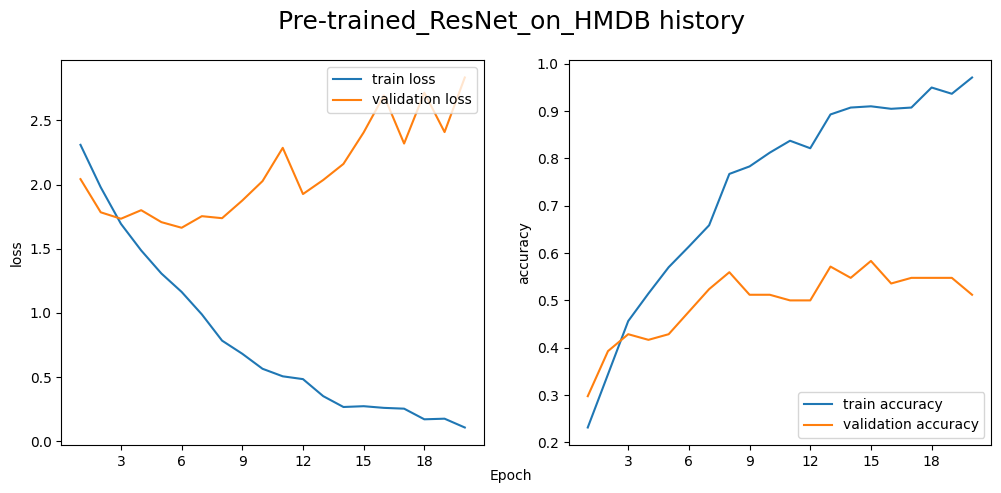

<Figure size 640x480 with 0 Axes>

In [33]:
plotHistory(history_hmdb, "Pre-trained_ResNet_on_HMDB")

In [96]:
model_hmdb_pretrained = MyResNet(input_size=(HEIGHT,WIDTH,3), classes=12)
model_hmdb_pretrained.load_weights(CKPT_PATH_HMDB_PRETRAINED).expect_partial()
model_hmdb_pretrained.compile(loss="categorical_crossentropy",
                        optimizer=keras.optimizers.Adam(0.001),
                        metrics="accuracy")

model_hmdb_pretrained.evaluate(test_gen_frame, batch_size=64)

6/6 [==============================] - 1s 20ms/step - loss: 1.9676 - accuracy: 0.3472


[1.9676103591918945, 0.3472222089767456]

In [ ]:
gc.collect()
del model_hmdb_pretrained

# Optical Flow
### Functions to calculate optical flow, save the results, and create data loaders

In [34]:
def getFlowIndices(n: int, cap: cv2.VideoCapture):
    """Returns an array of n indices to be used for calculating optical flow
    TThe n frames are centered around the middle with steps of 2, 
    except for when the video is too short, where step is 1."""

    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    m = total_frames//2
    
    if m-n < 0:
        indices_below_middle = np.linspace(start=m, stop=0, num=8, dtype=int)
    else:
        indices_below_middle = np.arange(start=m, stop=m-n, step=-2)
    
    if m+2+n > total_frames:
        indices_above_middle = np.linspace(start=m+1, stop=total_frames, num=8, dtype=int)
    else:
        indices_above_middle = np.arange(start=m+2, stop=m+2+n, step=2)

    indices = np.concatenate((indices_below_middle, indices_above_middle), axis=0)
    indices = np.sort(indices)
    return indices

In [35]:
FARNEBACK_PARAMS = dict(
    pyr_scale=0.5,  # image scale (<1) to build pyramids
    levels=3,       # number of pyramid layers
    winsize=15,     # size of the window used to find optical flow
    iterations=3,   # number of iterations at each pyramid level
    poly_n=5,       # size of the pixel neighborhood used to find polynomial expansion
    poly_sigma=1.2, # standard deviation of the Gaussian used to smooth derivatives
    flags=0         # miscellaneous flags (e.g., use previous flow estimate to speed up processing)
)


def NewCreateOpticalFlows(vid_path: pathlib.PosixPath, n: int):
    cap = cv2.VideoCapture(str(vid_path))
    frames = getFlowIndices(n=n, cap=cap)

    ret, frame1 = cap.read()
    frame1 = cv2.resize(frame1, (HEIGHT, WIDTH), interpolation=cv2.INTER_AREA)
    prev = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    c = 0
    # 72x72 flows of 2 channels (x,y direction) for 16 frames
    vid_flows = np.empty((n, HEIGHT, WIDTH, 2))
    i = 0
    while(True):
        ret, frame2 = cap.read() # frame is 1, prev is frame 0
        if not ret:
            break
        frame2 = cv2.resize(frame2, (HEIGHT, WIDTH), interpolation=cv2.INTER_AREA)
        frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        if c in frames:
            flow = cv2.calcOpticalFlowFarneback(prev, frame2, None, **FARNEBACK_PARAMS)
            vid_flows[i, ] = flow
            i += 1  

        prev = frame2
        c += 1
    cap.release()
    return vid_flows

In [36]:
def writeAllOpticalFlows(n: int, files, labels):
    path = pathlib.Path.cwd() / "video_data"
    flow_path = pathlib.Path.cwd() / "flow_data"

    all_labels = sorted(list(set(labels)))
    [(flow_path / label).mkdir(parents=True, exist_ok=True) for label in all_labels]

    for idx, (file, label) in enumerate(zip(files, labels)):
        if idx % 250 == 0:
            print("now at video:", idx, "out of", len(files))
        
        video_path = path / label / file
        full_flow_path = flow_path / label / file.split(".")[0]
        
        vid_flows = NewCreateOpticalFlows(video_path, n)
        np.save(full_flow_path, vid_flows)

### Custom data generator for the optical flow arrays (batch_size, 16, height, width)

In [37]:
class FlowDataGenerator(keras.utils.Sequence):

    action_categories_hmdb = sorted(list(set(all_train_labels_hmdb)))

    def __init__(self, data_dir, batch_size, files, labels):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.files = [data_dir / label / (str(file).split(".")[0] + ".npy") for file, label in zip(files, labels)]
        self.labels = labels
    
    def __len__(self):
        return int(np.ceil(len(self.files) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_files = self.files[idx * self.batch_size:(idx + 1) * self.batch_size]
        data = np.array([np.load(file) for file in batch_files])

        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        """instead of using LabelBinarizer to one-hot encode the labels, 
        manually create one-hot encoded label vectors for each batch sample.
         This ensures that all labels are present in the output array, 
         even if they are not present in the current batch."""
        labels = []
        for label in batch_labels: 
            label_index = self.action_categories_hmdb.index(label)
            label_vector = np.zeros(len(self.action_categories_hmdb))
            label_vector[label_index] = 1
            labels.append(label_vector)
        labels = np.array(labels)

        return data, labels

# Define the 2+1D CNN
* https://www.tensorflow.org/tutorials/video/video_classification

In [38]:
class Conv2Plus1D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding):
        """
        A sequence of convolutional layers that first apply the convolution operation over the
        spatial dimensions, and then the temporal dimension. 
        """
        super().__init__()
        self.seq = keras.Sequential([  
            # Spatial decomposition
            layers.Conv3D(filters=filters,
                        kernel_size=(1, kernel_size[1], kernel_size[2]),
                        padding=padding),
            # Temporal decomposition
            layers.Conv3D(filters=filters, 
                        kernel_size=(kernel_size[0], 1, 1),
                        padding=padding)
            ])

    def call(self, x):
        return self.seq(x)


class ResidualMain(keras.layers.Layer):
    """
        Residual block of the model with convolution, layer normalization, and the
        activation function, ReLU.
    """
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.seq = keras.Sequential([
            Conv2Plus1D(filters=filters,
                        kernel_size=kernel_size,
                        padding='same'),
            # layers.LayerNormalization(),
            layers.ReLU(),
            Conv2Plus1D(filters=filters, 
                        kernel_size=kernel_size,
                        padding='same'),
            # layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)


class Project(keras.layers.Layer):
    """
        Project certain dimensions of the tensor as the data is passed through different 
        sized filters and downsampled. 
    """
    def __init__(self, units):
        super().__init__()
        self.seq = keras.Sequential([
            layers.Dense(units),
            # layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)

def add_residual_block(input, filters, kernel_size):
    """
        Add residual blocks to the model. If the last dimensions of the input data
        and filter size does not match, project it such that last dimension matches.
    """
    out = ResidualMain(filters, 
                        kernel_size)(input)

    res = input
    # Using the Keras functional APIs, project the last dimension of the tensor to
    # match the new filter size
    if out.shape[-1] != input.shape[-1]:
        res = Project(out.shape[-1])(res)

    return layers.add([res, out])


In [39]:
def buildConv2Plus1():
    input_shape = (None, 16, HEIGHT, WIDTH, 2)
    input = layers.Input(shape=(input_shape[1:]))
    x = input

    x = Conv2Plus1D(filters=8, kernel_size=(3, 3, 3), padding="same")(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Block 1
    x = add_residual_block(x, 16, (3, 3, 3))
    x = layers.MaxPool3D(pool_size=2)(x)

    # Block 2
    x = add_residual_block(x, 32, (3, 3, 3))
    x = layers.MaxPool3D(pool_size=2)(x)

    # Block 3
    x = add_residual_block(x, 64, (3, 3, 3))
    x = layers.MaxPool3D(pool_size=2)(x)
    # x = Dropout(0.5)(x)

    # Block 4
    x = add_residual_block(x, 128, (3, 3, 3))
    x = layers.GlobalAveragePooling3D()(x)
    # x = Dropout(0.5)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = Dropout(0.35)(x)
    x = layers.Dense(12, activation="softmax")(x)

    model = keras.Model(input, x)

    return model

# Run optical flow calculations and the 2+1D model

In [40]:
# all_train_files_hmdb, test_files_hmdb, all_train_labels_hmdb, test_labels_hmdb = getTrainTestFiles()
# train_files_hmdb, val_files_hmdb, train_labels_hmdb, val_labels_hmdb = train_test_split(all_train_files_hmdb, all_train_labels_hmdb, test_size=0.1, random_state=0, stratify=all_train_labels_hmdb)

writeAllOpticalFlows(16, train_files_hmdb, train_labels_hmdb)
writeAllOpticalFlows(16, val_files_hmdb, val_labels_hmdb)
writeAllOpticalFlows(16, test_files_hmdb, test_labels_hmdb)

now at video: 0 out of 756
now at video: 250 out of 756
now at video: 500 out of 756
now at video: 750 out of 756
now at video: 0 out of 84
now at video: 0 out of 360
now at video: 250 out of 360


In [41]:
# Instantiate flow data generators
flow_path = pathlib.Path.cwd() / "flow_data"
train_gen_flow = FlowDataGenerator(flow_path, 64, train_files_hmdb, train_labels_hmdb)
val_gen_flow = FlowDataGenerator(flow_path, 64, val_files_hmdb, val_labels_hmdb)
test_gen_flow = FlowDataGenerator(flow_path, 64, test_files_hmdb, test_labels_hmdb)

In [70]:
model2plus1 = buildConv2Plus1()

callback_ckpt = ModelCheckpoint(CKPT_PATH_FLOW, 
                               save_best_only=True, 
                               save_weights_only=True, 
                               monitor="val_accuracy", 
                               mode="max")

callback_early_stop = EarlyStopping(monitor="val_loss", 
                                    patience=8, 
                                    verbose=1, 
                                    mode="min", restore_best_weights=True)

model2plus1.compile(loss="categorical_crossentropy",
                   optimizer=keras.optimizers.Adam(0.001), # clr doesn't improve
                   metrics="accuracy")

history_flow = model2plus1.fit(train_gen_flow, validation_data=val_gen_flow, 
                             epochs=12,
                             verbose=1, 
                             shuffle=True, callbacks=[callback_early_stop, callback_ckpt])

12/12 [==============================] - 6s 488ms/step - loss: 2.3634 - accuracy: 0.1455 - val_loss: 2.2552 - val_accuracy: 0.2143
Epoch 3/12
12/12 [==============================] - 6s 457ms/step - loss: 2.3439 - accuracy: 0.1548 - val_loss: 2.2053 - val_accuracy: 0.2262
Epoch 4/12
12/12 [==============================] - 6s 462ms/step - loss: 2.2797 - accuracy: 0.1627 - val_loss: 2.2132 - val_accuracy: 0.2024
Epoch 5/12
12/12 [==============================] - 6s 490ms/step - loss: 2.2364 - accuracy: 0.2050 - val_loss: 2.1929 - val_accuracy: 0.2500
Epoch 6/12
12/12 [==============================] - 6s 466ms/step - loss: 2.2206 - accuracy: 0.1997 - val_loss: 2.1613 - val_accuracy: 0.1905
Epoch 7/12
12/12 [==============================] - 6s 474ms/step - loss: 2.2063 - accuracy: 0.2103 - val_loss: 2.1639 - val_accuracy: 0.2024
Epoch 8/12
12/12 [==============================] - 6s 471ms/step - loss: 2.1739 - accuracy: 0.2103 - val_loss: 2.1368 - val_accuracy: 0.2262
Epoch 9/12
12/12 

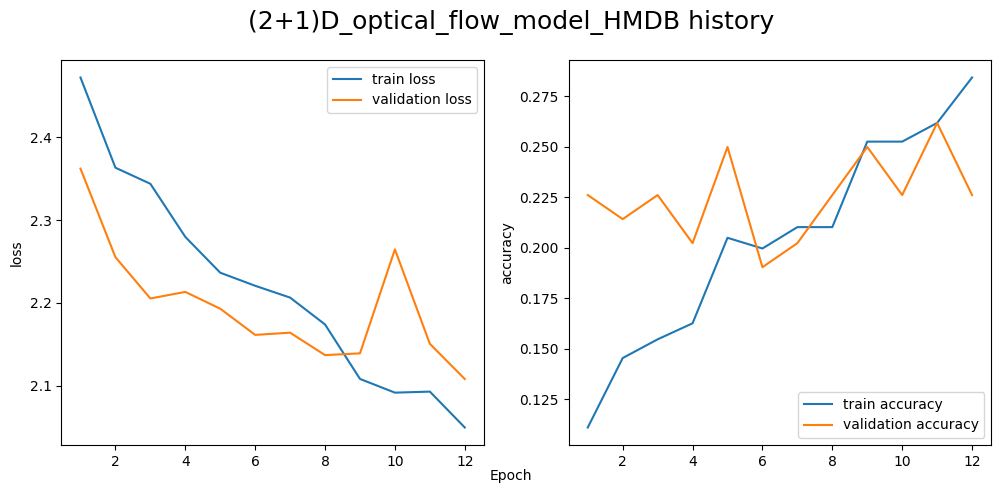

<Figure size 640x480 with 0 Axes>

In [72]:
plotHistory(history_flow, "(2+1)D_optical_flow_model_HMDB")

In [71]:
model2plus1 = buildConv2Plus1()
model2plus1.load_weights(CKPT_PATH_FLOW)
model2plus1.compile(loss="categorical_crossentropy",
                   optimizer=keras.optimizers.Adam(0.001),
                   metrics="accuracy")

model2plus1.evaluate(test_gen_flow, batch_size=64)

6/6 [==============================] - 2s 140ms/step - loss: 2.2145 - accuracy: 0.2639


[2.2144787311553955, 0.2638888955116272]

In [ ]:
plot_model(model2plus1, to_file=MODEL_ARCHITECTURES_PATH + "/optical_flow_model.jpg", expand_nested=True, dpi=60, show_shapes=True)

# TWO-STREAM NETWORK

### Custom dual data generator for the two-stream model

In [97]:
class DualDataGenerator(keras.utils.Sequence):
    def __init__(self, frame_gen, flow_gen):
        self.frame_gen = frame_gen
        self.flow_gen = flow_gen
    
    def __len__(self):
        return self.flow_gen.__len__()
    
    def __getitem__(self, idx):
        frame_batch = self.frame_gen.__getitem__(idx)
        flow_batch = self.flow_gen.__getitem__(idx)
        data = [frame_batch[0], flow_batch[0]]
        labels = flow_batch[1]
        return data, labels

In [98]:
train_gen_dual = DualDataGenerator(train_gen_frame, train_gen_flow)
val_gen_dual = DualDataGenerator(val_gen_frame, val_gen_flow)
test_gen_dual = DualDataGenerator(test_gen_frame, test_gen_flow)

In [141]:
def getPretrainedModelsOutput(hmdb_frames_path: str, hmdb_flow_path: str):
    # hmdb model
    model_hmdb_pretrained = MyResNet(input_size=(HEIGHT,WIDTH,3), classes=12)
    model_hmdb_pretrained.load_weights(hmdb_frames_path).expect_partial()
    
    unfreeze(model_hmdb_pretrained, 0)

    # optical flow model
    model2plus1 = buildConv2Plus1()
    model2plus1.load_weights(hmdb_flow_path).expect_partial()
    unfreeze(model2plus1, 0)

    return model_hmdb_pretrained, model2plus1

def getOutputAfterFusion(fusion_type: str):
    if fusion_type == "avg":
        fusion = Average()([output_spatial, output_flow])
        ckpt_path_two_stream = CKPT_PATH_TWO_STREAM_AVG
    elif fusion_type == "conc":
        fusion = Concatenate()([output_spatial, output_flow])
        ckpt_path_two_stream = CKPT_PATH_TWO_STREAM_CONC
    elif fusion_type == "max":
        fusion = Maximum()([output_spatial, output_flow])
        ckpt_path_two_stream = CKPT_PATH_TWO_STREAM_MAX
    elif fusion_type == "min":
        fusion = Minimum()([output_spatial, output_flow])
        ckpt_path_two_stream = CKPT_PATH_TWO_STREAM_MIN
    else:
        print("fusion_type can only be one of: avg, conc, max, min")
        return

    x = Flatten()(fusion)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(12, activation='softmax', name='fusion_output')(x)

    return output, ckpt_path_two_stream

def twoStreamModel(model_hmdb_pretrained: Functional, model2plus1: Functional, output: KerasTensor, ckpt_path_two_stream: str):
    model_two_stream = Model(inputs=[model_hmdb_pretrained.input, model2plus1.input], outputs=[output])

    callback_ckpt = ModelCheckpoint(ckpt_path_two_stream, 
                                save_best_only=True, 
                                save_weights_only=True, 
                                monitor='val_loss', 
                                mode='min')
    
    callback_early_stop = EarlyStopping(monitor="val_loss", 
                                    patience=3, 
                                    verbose=1, 
                                    mode="min", restore_best_weights=True)
    
    model_two_stream.compile(loss="categorical_crossentropy",
                            optimizer=keras.optimizers.Adam(0.001), # CLR didn't improve
                            metrics="accuracy")

    two_stream_history = model_two_stream.fit(train_gen_dual, 
                                    validation_data=val_gen_dual, 
                                    epochs=20,
                                    verbose=1,
                                    steps_per_epoch=len(train_gen_frame),
                                    shuffle=True, callbacks=[callback_ckpt, callback_early_stop])

    return model_two_stream, two_stream_history

In [ ]:
gc.collect()
del model2plus1, model_hmdb_pretrained

# CHOICE TASK: DIFFERENT TYPES OF FUSION
* for each type of fusion, run all cells from the beginning because some variable are overwritten

### Average fusion

In [148]:
model_hmdb_pretrained, model2plus1 = getPretrainedModelsOutput(CKPT_PATH_HMDB_PRETRAINED, CKPT_PATH_FLOW)

# output from the second to last layer (fully-connected)
output_spatial = model_hmdb_pretrained.layers[-1].output
output_flow = model2plus1.layers[-1].output

output, ckpt_path_two_stream = getOutputAfterFusion("avg")

two_stream_model_avg, two_stream_history_avg = twoStreamModel(model_hmdb_pretrained,
                                                              model2plus1,
                                                              output,
                                                              ckpt_path_two_stream)

Epoch 1/20
12/12 [==============================] - 8s 333ms/step - loss: 2.4747 - accuracy: 0.1151 - val_loss: 2.4602 - val_accuracy: 0.2738
Epoch 2/20
12/12 [==============================] - 3s 214ms/step - loss: 2.4440 - accuracy: 0.2421 - val_loss: 2.4356 - val_accuracy: 0.3929
Epoch 3/20
12/12 [==============================] - 3s 232ms/step - loss: 2.4186 - accuracy: 0.3201 - val_loss: 2.4105 - val_accuracy: 0.4643
Epoch 4/20
12/12 [==============================] - 4s 290ms/step - loss: 2.3917 - accuracy: 0.3849 - val_loss: 2.3837 - val_accuracy: 0.4881
Epoch 5/20
12/12 [==============================] - 3s 227ms/step - loss: 2.3521 - accuracy: 0.4511 - val_loss: 2.3542 - val_accuracy: 0.5238
Epoch 6/20
12/12 [==============================] - 3s 221ms/step - loss: 2.3197 - accuracy: 0.4775 - val_loss: 2.3213 - val_accuracy: 0.5238
Epoch 7/20
12/12 [==============================] - 3s 242ms/step - loss: 2.2775 - accuracy: 0.4828 - val_loss: 2.2847 - val_accuracy: 0.5238
Epoch 

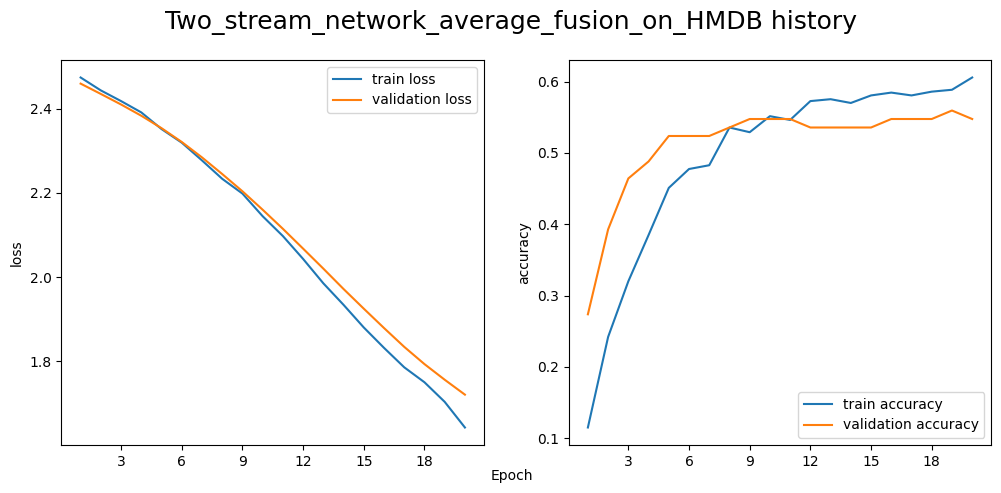

<Figure size 640x480 with 0 Axes>

In [150]:
plotHistory(two_stream_history_avg, "Two_stream_network_average_fusion_on_HMDB")

In [149]:
two_stream_model_avg = Model(inputs=[model_hmdb_pretrained.input, model2plus1.input], outputs=[output])

two_stream_model_avg.load_weights(CKPT_PATH_TWO_STREAM_AVG).expect_partial()
two_stream_model_avg.compile(loss="categorical_crossentropy",
                        optimizer=keras.optimizers.Adam(0.001),
                        metrics="accuracy")

two_stream_model_avg.evaluate(test_gen_dual, batch_size=64)

6/6 [==============================] - 3s 185ms/step - loss: 1.9609 - accuracy: 0.3972


[1.9608632326126099, 0.39722222089767456]

In [ ]:
plot_model(two_stream_model_avg, to_file=MODEL_ARCHITECTURES_PATH + "/two_stream_model.jpg", expand_nested=True, dpi=60, show_shapes=True)

In [ ]:
gc.collect()
del two_stream_model_avg

### Concatenation fusion

In [121]:
model_hmdb_pretrained, model2plus1 = getPretrainedModelsOutput(CKPT_PATH_HMDB_PRETRAINED, CKPT_PATH_FLOW)

# output from the second to last layer (fully-connected)
output_spatial = model_hmdb_pretrained.layers[-1].output
output_flow = model2plus1.layers[-1].output

output, ckpt_path_two_stream = getOutputAfterFusion("conc")

two_stream_model_conc, two_stream_history_conc = twoStreamModel(model_hmdb_pretrained,
                                                              model2plus1,
                                                              output,
                                                              ckpt_path_two_stream)

Epoch 1/20
12/12 [==============================] - 6s 287ms/step - loss: 2.4745 - accuracy: 0.1032 - val_loss: 2.4528 - val_accuracy: 0.1429
Epoch 2/20
12/12 [==============================] - 3s 219ms/step - loss: 2.4184 - accuracy: 0.2302 - val_loss: 2.4059 - val_accuracy: 0.3571
Epoch 3/20
12/12 [==============================] - 3s 257ms/step - loss: 2.3670 - accuracy: 0.3452 - val_loss: 2.3563 - val_accuracy: 0.4881
Epoch 4/20
12/12 [==============================] - 3s 208ms/step - loss: 2.3095 - accuracy: 0.4418 - val_loss: 2.3016 - val_accuracy: 0.5238
Epoch 5/20
12/12 [==============================] - 3s 214ms/step - loss: 2.2433 - accuracy: 0.4894 - val_loss: 2.2415 - val_accuracy: 0.5119
Epoch 6/20
12/12 [==============================] - 3s 275ms/step - loss: 2.1737 - accuracy: 0.5450 - val_loss: 2.1761 - val_accuracy: 0.5238
Epoch 7/20
12/12 [==============================] - 3s 240ms/step - loss: 2.1027 - accuracy: 0.5423 - val_loss: 2.1079 - val_accuracy: 0.5119
Epoch 

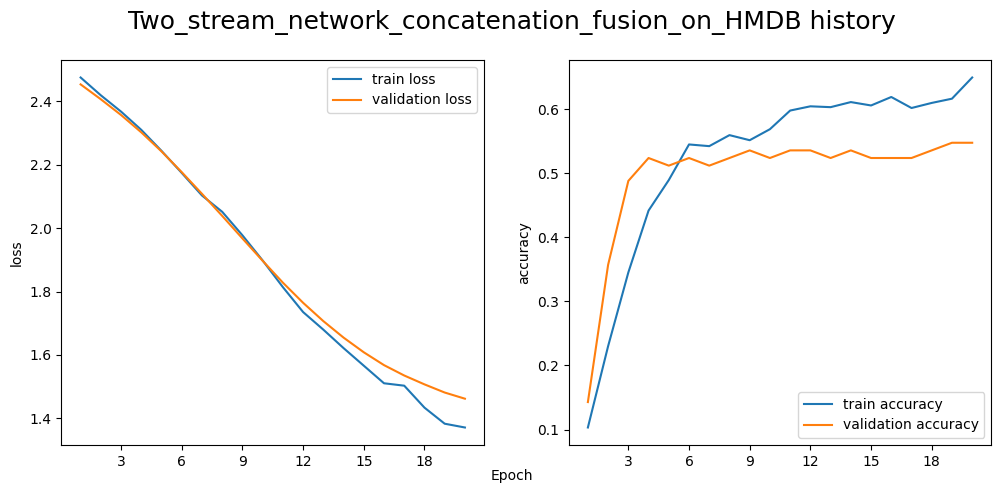

<Figure size 640x480 with 0 Axes>

In [122]:
plotHistory(two_stream_history_conc, "Two_stream_network_concatenation_fusion_on_HMDB")

In [123]:
two_stream_model_conc = Model(inputs=[model_hmdb_pretrained.input, model2plus1.input], outputs=[output])
two_stream_model_conc.load_weights(CKPT_PATH_TWO_STREAM_CONC).expect_partial()
two_stream_model_conc.compile(loss="categorical_crossentropy",
                        optimizer=keras.optimizers.Adam(0.001),
                        metrics="accuracy")
two_stream_model_conc.evaluate(test_gen_dual, batch_size=64)

6/6 [==============================] - 2s 160ms/step - loss: 1.8148 - accuracy: 0.4028


[1.8148385286331177, 0.4027777910232544]

In [ ]:
gc.collect()
del two_stream_model_conc

### Minimum fusion

In [124]:
model_hmdb_pretrained, model2plus1 = getPretrainedModelsOutput(CKPT_PATH_HMDB_PRETRAINED, CKPT_PATH_FLOW)

# output from the second to last layer (fully-connected)
output_spatial = model_hmdb_pretrained.layers[-1].output
output_flow = model2plus1.layers[-1].output

output, ckpt_path_two_stream = getOutputAfterFusion("min")

two_stream_model_min, two_stream_history_min = twoStreamModel(model_hmdb_pretrained,
                                                              model2plus1,
                                                              output,
                                                              ckpt_path_two_stream)

Epoch 1/20
12/12 [==============================] - 6s 284ms/step - loss: 2.4821 - accuracy: 0.1071 - val_loss: 2.4735 - val_accuracy: 0.1786
Epoch 2/20
12/12 [==============================] - 3s 221ms/step - loss: 2.4655 - accuracy: 0.2143 - val_loss: 2.4614 - val_accuracy: 0.2857
Epoch 3/20
12/12 [==============================] - 3s 233ms/step - loss: 2.4484 - accuracy: 0.2989 - val_loss: 2.4490 - val_accuracy: 0.3810
Epoch 4/20
12/12 [==============================] - 3s 222ms/step - loss: 2.4342 - accuracy: 0.3307 - val_loss: 2.4354 - val_accuracy: 0.3929
Epoch 5/20
12/12 [==============================] - 3s 274ms/step - loss: 2.4165 - accuracy: 0.3466 - val_loss: 2.4208 - val_accuracy: 0.3690
Epoch 6/20
12/12 [==============================] - 3s 218ms/step - loss: 2.3991 - accuracy: 0.3717 - val_loss: 2.4048 - val_accuracy: 0.3571
Epoch 7/20
12/12 [==============================] - 3s 216ms/step - loss: 2.3760 - accuracy: 0.3849 - val_loss: 2.3865 - val_accuracy: 0.4048
Epoch 

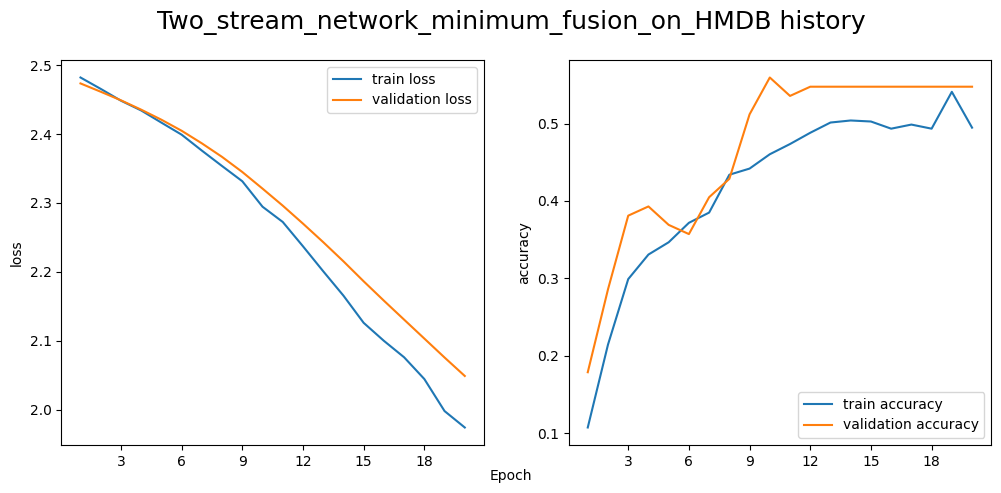

<Figure size 640x480 with 0 Axes>

In [125]:
plotHistory(two_stream_history_min, "Two_stream_network_minimum_fusion_on_HMDB")

In [126]:
two_stream_model_min = Model(inputs=[model_hmdb_pretrained.input, model2plus1.input], outputs=[output])
two_stream_model_min.load_weights(CKPT_PATH_TWO_STREAM_MIN).expect_partial()
two_stream_model_min.compile(loss="categorical_crossentropy",
                        optimizer=keras.optimizers.Adam(0.001),
                        metrics="accuracy")
two_stream_model_min.evaluate(test_gen_dual, batch_size=64)

6/6 [==============================] - 2s 158ms/step - loss: 2.0899 - accuracy: 0.3833


[2.089948892593384, 0.38333332538604736]

In [ ]:
gc.collect()
del two_stream_model_min

### Maximum fusion

In [127]:
model_hmdb_pretrained, model2plus1 = getPretrainedModelsOutput(CKPT_PATH_HMDB_PRETRAINED, CKPT_PATH_FLOW)

# output from the second to last layer (fully-connected)
output_spatial = model_hmdb_pretrained.layers[-1].output
output_flow = model2plus1.layers[-1].output

output, ckpt_path_two_stream = getOutputAfterFusion("max")

two_stream_model_max, two_stream_history_max = twoStreamModel(model_hmdb_pretrained,
                                                              model2plus1,
                                                              output,
                                                              ckpt_path_two_stream)

Epoch 1/20
12/12 [==============================] - 7s 289ms/step - loss: 2.4736 - accuracy: 0.0860 - val_loss: 2.4532 - val_accuracy: 0.0595
Epoch 2/20
12/12 [==============================] - 3s 259ms/step - loss: 2.4247 - accuracy: 0.1892 - val_loss: 2.4128 - val_accuracy: 0.1667
Epoch 3/20
12/12 [==============================] - 3s 238ms/step - loss: 2.3820 - accuracy: 0.2950 - val_loss: 2.3696 - val_accuracy: 0.3690
Epoch 4/20
12/12 [==============================] - 3s 221ms/step - loss: 2.3362 - accuracy: 0.4140 - val_loss: 2.3232 - val_accuracy: 0.4405
Epoch 5/20
12/12 [==============================] - 3s 217ms/step - loss: 2.2756 - accuracy: 0.4854 - val_loss: 2.2721 - val_accuracy: 0.4524
Epoch 6/20
12/12 [==============================] - 3s 239ms/step - loss: 2.2206 - accuracy: 0.5106 - val_loss: 2.2170 - val_accuracy: 0.4643
Epoch 7/20
12/12 [==============================] - 3s 262ms/step - loss: 2.1633 - accuracy: 0.5397 - val_loss: 2.1607 - val_accuracy: 0.4762
Epoch 

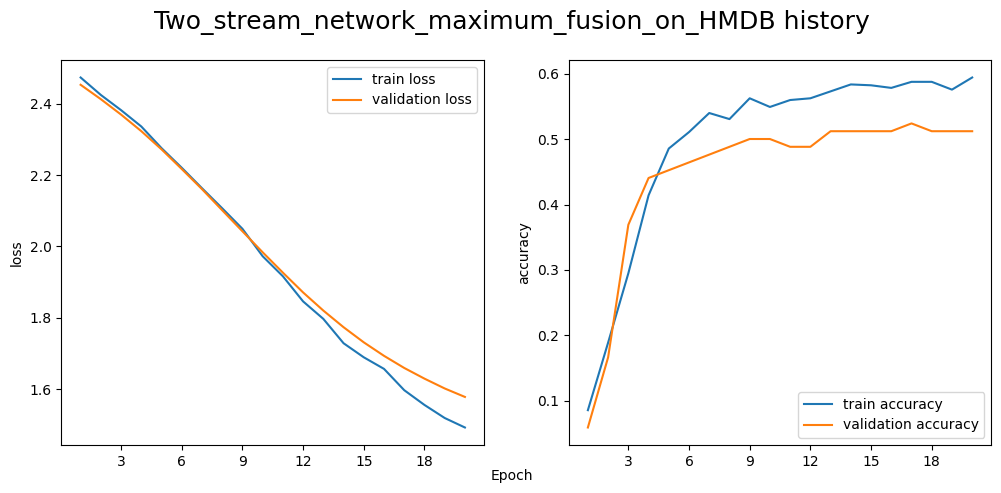

<Figure size 640x480 with 0 Axes>

In [128]:
plotHistory(two_stream_history_max, "Two_stream_network_maximum_fusion_on_HMDB")

In [129]:
two_stream_model_max = Model(inputs=[model_hmdb_pretrained.input, model2plus1.input], outputs=[output])
two_stream_model_max.load_weights(CKPT_PATH_TWO_STREAM_MAX).expect_partial()
two_stream_model_max.compile(loss="categorical_crossentropy",
                        optimizer=keras.optimizers.Adam(0.001),
                        metrics="accuracy")
two_stream_model_max.evaluate(test_gen_dual, batch_size=64)

6/6 [==============================] - 2s 156ms/step - loss: 1.9324 - accuracy: 0.3472


[1.9323614835739136, 0.3472222089767456]

In [ ]:
gc.collect()
del two_stream_model_max